### Problem Statement 

A Binary classification problem on checking whether the customer is eligible for the credit. 

### Importing all the libraries needed

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

import plotly
import plotly.offline as pyoff
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

from numpy import asarray
from numpy import savetxt
from numpy import loadtxt

Using TensorFlow backend.


In [2]:
from __future__ import print_function

import numpy as np
import pandas as pd
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10) 

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.1.0


### Reading the Training dataset

In [3]:
data = pd.read_csv("cs-training.csv", sep=',', header=0)
data = data.rename(columns = {'Unnamed: 0':'id'})

### EDA on the Data

In [4]:
data.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
print(data.shape)
print(list(data.columns))
print((data.dtypes))

(150000, 12)
['id', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
id                                        int64
SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object


### Correlation of data

In [6]:
corr=data.corr()
print(corr)

                                            id  SeriousDlqin2yrs  \
id                                    1.000000          0.002801   
SeriousDlqin2yrs                      0.002801          1.000000   
RevolvingUtilizationOfUnsecuredLines  0.002372         -0.001802   
age                                   0.004403         -0.115386   
NumberOfTime30-59DaysPastDueNotWorse -0.000571          0.125587   
DebtRatio                            -0.002906         -0.007602   
MonthlyIncome                         0.002632         -0.019746   
NumberOfOpenCreditLinesAndLoans       0.004586         -0.029669   
NumberOfTimes90DaysLate              -0.001104          0.117175   
NumberRealEstateLoansOrLines         -0.000666         -0.007038   
NumberOfTime60-89DaysPastDueNotWorse -0.000777          0.102261   
NumberOfDependents                   -0.000055          0.046048   

                                      RevolvingUtilizationOfUnsecuredLines  \
id                                   

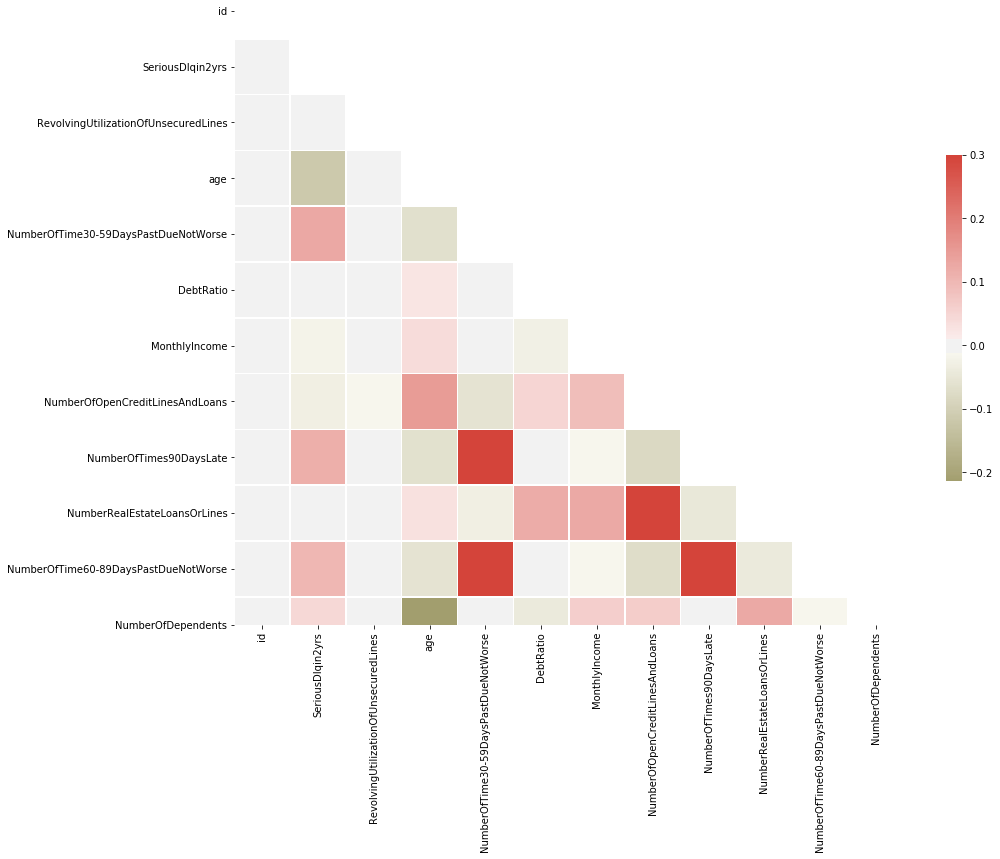

In [7]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(800, 14, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [8]:
data.drop("id", axis = 1, inplace= True)

### Distribution of the target variable

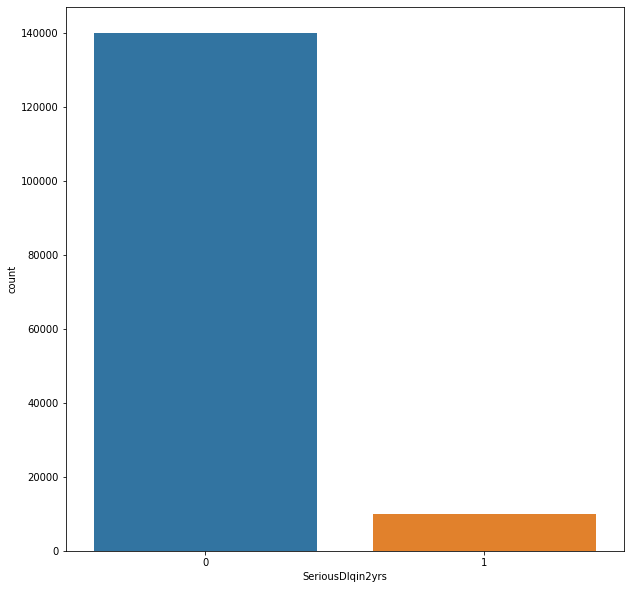

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64


In [9]:
sns.countplot(x='SeriousDlqin2yrs',data=data)
plt.show()

# What are the counts?
print(data.SeriousDlqin2yrs.value_counts())

#### ----Class Imbalance is identified----

### Looking for missing or NA values

In [10]:
# Check missing values
print(data.isnull().sum(axis=0))

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


### Imputing the missing data with mean

In [11]:
# Generate missing imputators variables.
data['MonthlyIncomeMissing'] = data.apply(lambda row: 1 if pd.isnull(row['MonthlyIncome']) else 0, axis=1)
data['NumberOfDependentsMissing'] = data.apply(lambda row: 1 if pd.isnull(row['NumberOfDependents']) else 0, axis=1)

# Impute missing values by the mean
data = data.fillna(data.mean())

In [12]:
# Check missing values
print(data.isnull().sum(axis=0))

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
MonthlyIncomeMissing                    0
NumberOfDependentsMissing               0
dtype: int64


In [13]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncomeMissing,NumberOfDependentsMissing
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222,0.198207,0.026160
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.288045e+04,5.145951,4.169304,1.129771,4.155179,1.100404,0.398650,0.159611
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,6.600000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000,1.000000,1.000000


In [14]:
print((data.dtypes))

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
MonthlyIncomeMissing                      int64
NumberOfDependentsMissing                 int64
dtype: object


### Train and test split

In [15]:
# Separate train test and convert to numpy arrays
from sklearn.model_selection import train_test_split

input_vars = ['RevolvingUtilizationOfUnsecuredLines',
             'age',
             'NumberOfTime30-59DaysPastDueNotWorse',
             'DebtRatio',
             'MonthlyIncome',
             'NumberOfOpenCreditLinesAndLoans',
             'NumberOfTimes90DaysLate',
             'NumberRealEstateLoansOrLines',
             'NumberOfTime60-89DaysPastDueNotWorse',
             'NumberOfDependents',
             'MonthlyIncomeMissing',
             'NumberOfDependentsMissing']

target_var = ['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(data[input_vars], data[target_var], test_size=0.2, random_state=42)
X_train = np.array(X_train, dtype=np.float32)
X_test  = np.array(X_test,  dtype=np.float32)
y_train = np.array(y_train, dtype=np.uint8)
y_test  = np.array(y_test,  dtype=np.uint8)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(120000, 12) (30000, 12)
(120000, 1) (30000, 1)


### Handling Imbalance data using SMOTE

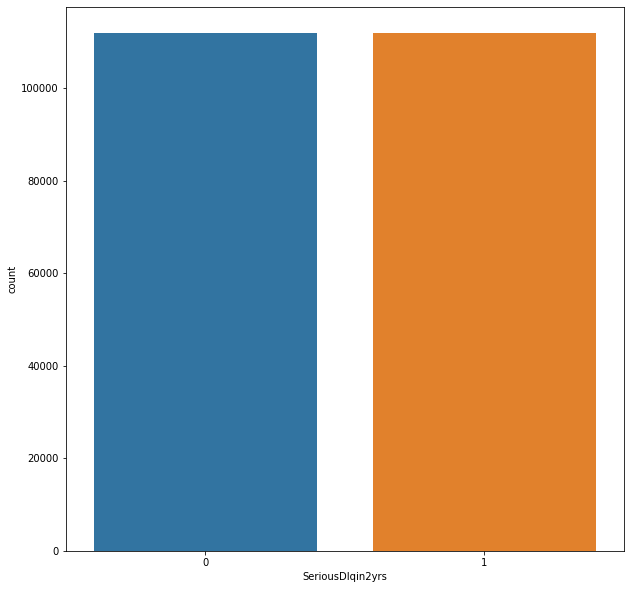

1    111930
0    111930
Name: SeriousDlqin2yrs, dtype: int64


In [16]:
smote = SMOTE(random_state=0)


os_train_x,os_train_y=smote.fit_sample(X_train, y_train)

os_train_x = pd.DataFrame(data=os_train_x)
os_train_y= pd.DataFrame(data=os_train_y,columns=['SeriousDlqin2yrs'])

sns.countplot(x='SeriousDlqin2yrs',data=os_train_y)
plt.show()

# What are the counts?
print(os_train_y.SeriousDlqin2yrs.value_counts())

### Model 1: Linear model standard parameters

In [17]:
# First model - Linear model

import tensorflow as tf

print('Linear model...')
input_data =  tf.keras.layers.Input(batch_shape=(None, 12), dtype='float32', name='Input_data') 

output_data =  tf.keras.layers.Dense(2, activation='softmax', name='Dense_output')(input_data)

# Model Architecture defined
model_linear = tf.keras.models.Model(inputs=input_data, outputs=output_data)
model_linear.summary()

Linear model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_data (InputLayer)      [(None, 12)]              0         
_________________________________________________________________
Dense_output (Dense)         (None, 2)                 26        
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Select optimizer and compile model
model_linear.compile(loss='sparse_categorical_crossentropy',  optimizer='Adam', metrics=['accuracy'])

In [19]:
# Train the model
history_linear = model_linear.fit(os_train_x, os_train_y, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, y_test))

Train on 223860 samples, validate on 30000 samples
Epoch 1/20
223860/223860 [==============================] - 2s 8us/sample - loss: 85.5499 - accuracy: 0.5756 - val_loss: 0.9267 - val_accuracy: 0.5013
Epoch 2/20
223860/223860 [==============================] - 1s 7us/sample - loss: 0.8459 - accuracy: 0.6789 - val_loss: 0.5116 - val_accuracy: 0.8971
Epoch 3/20
223860/223860 [==============================] - 2s 7us/sample - loss: 1.1113 - accuracy: 0.6821 - val_loss: 0.4576 - val_accuracy: 0.9122
Epoch 4/20
223860/223860 [==============================] - 2s 7us/sample - loss: 1.1714 - accuracy: 0.6824 - val_loss: 0.9703 - val_accuracy: 0.5247
Epoch 5/20
223860/223860 [==============================] - 2s 8us/sample - loss: 0.7952 - accuracy: 0.6934 - val_loss: 0.7408 - val_accuracy: 0.7409accuracy:  - ETA: 0s - loss: 0.8079 - accuracy: 0.
Epoch 6/20
223860/223860 [==============================] - 2s 7us/sample - loss: 0.8476 - accuracy: 0.6883 - val_loss: 1.0092 - val_accuracy: 0.458

In [20]:
print(history_linear.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


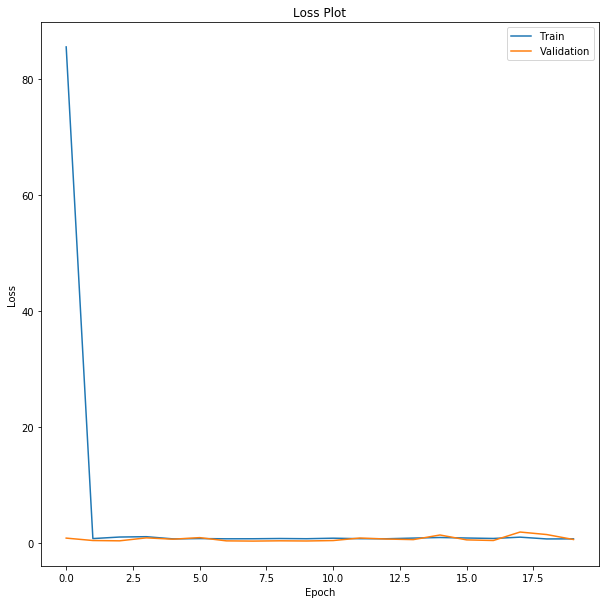

In [21]:
plt.plot(history_linear.history['loss'])
plt.plot(history_linear.history['val_loss'])
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

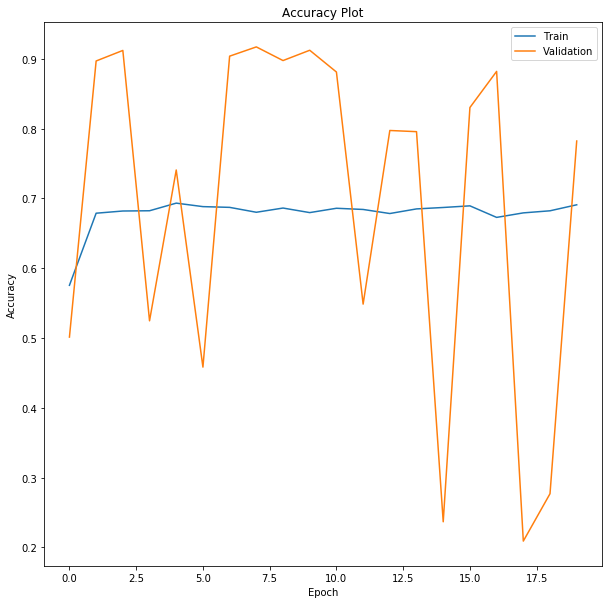

In [22]:
plt.plot(history_linear.history['accuracy'])
plt.plot(history_linear.history['val_accuracy'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [23]:
from sklearn import metrics

p_test = model_linear.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, p_test[:,1], pos_label=1)
print('ROC area Linear model:', metrics.auc(fpr, tpr))

ROC area Linear model: 0.7854360617656333


In [24]:
#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix

pred_test = np.argmax(p_test, axis=1)
print(confusion_matrix(y_test, pred_test))
cf1=confusion_matrix(y_test, pred_test)

[[22217  5827]
 [  701  1255]]


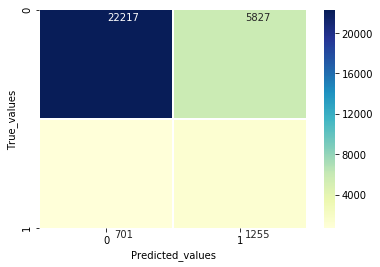

In [25]:
import seaborn as sns
import numpy as np; np.random.seed(0)
import matplotlib.pylab as plt
import matplotlib.transforms
#conf=confusion_matrix(y,pred)
plt.figure(figsize=(6,4))
ax=sns.heatmap(cf1,xticklabels=['0','1'],yticklabels=['0','1'],annot=True,fmt='d',cmap='YlGnBu',linewidths=0.5)
for t in ax.texts:
    trans = t.get_transform()
    offs = matplotlib.transforms.ScaledTranslation(0.13, 0.03,
                    matplotlib.transforms.IdentityTransform())
    t.set_transform( offs + trans )


plt.xlabel('Predicted_values')
plt.ylabel('True_values')
plt.show()


In [26]:
print(metrics.classification_report(y_test,pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.969     0.792     0.872     28044
           1      0.177     0.642     0.278      1956

    accuracy                          0.782     30000
   macro avg      0.573     0.717     0.575     30000
weighted avg      0.918     0.782     0.833     30000



### Model 2 Add 2 dense layers 

In [27]:
# Second model - Deep nn model
print('dense 1 model...')
input_data = tf.keras.layers.Input(batch_shape=(None, 12), dtype='float32', name='Input_data') 

dense1  = tf.keras.layers.Dense(256, activation='relu', name='Dense_layer_1')(input_data)
dense2  = tf.keras.layers.Dense(256, activation='relu', name='Dense_layer_2')(dense1)
    
output_data = tf.keras.layers.Dense(2, activation='softmax', name='Dense_output')(dense2)

# Model Architecture defined
model_dense1 = tf.keras.models.Model(inputs=input_data, outputs=output_data)
model_dense1.summary()

dense 1 model...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_data (InputLayer)      [(None, 12)]              0         
_________________________________________________________________
Dense_layer_1 (Dense)        (None, 256)               3328      
_________________________________________________________________
Dense_layer_2 (Dense)        (None, 256)               65792     
_________________________________________________________________
Dense_output (Dense)         (None, 2)                 514       
Total params: 69,634
Trainable params: 69,634
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Select optimizer and compile model
model_dense1.compile(loss='sparse_categorical_crossentropy',  optimizer='Adam', metrics=['accuracy'])

In [29]:
# Train the model
history_dense1 = model_dense1.fit(os_train_x, os_train_y, batch_size=128, epochs=40, verbose=1, validation_data=(X_test, y_test))

Train on 223860 samples, validate on 30000 samples
Epoch 1/40
223860/223860 [==============================] - 3s 14us/sample - loss: 22.6892 - accuracy: 0.5251 - val_loss: 4.8195 - val_accuracy: 0.1077oss: 
Epoch 2/40
223860/223860 [==============================] - 3s 14us/sample - loss: 4.4533 - accuracy: 0.5971 - val_loss: 1.1803 - val_accuracy: 0.4876
Epoch 3/40
223860/223860 [==============================] - 3s 13us/sample - loss: 1.4493 - accuracy: 0.6534 - val_loss: 0.3960 - val_accuracy: 0.9296
Epoch 4/40
223860/223860 [==============================] - 3s 13us/sample - loss: 1.0472 - accuracy: 0.6786 - val_loss: 0.3374 - val_accuracy: 0.9061
Epoch 5/40
223860/223860 [==============================] - 3s 13us/sample - loss: 0.8135 - accuracy: 0.6987 - val_loss: 0.5302 - val_accuracy: 0.8451
Epoch 6/40
223860/223860 [==============================] - 3s 13us/sample - loss: 0.6539 - accuracy: 0.7216 - val_loss: 0.8332 - val_accuracy: 0.4409ss: 0.6554 - accura
Epoch 7/40
223860/

In [30]:
print(history_dense1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


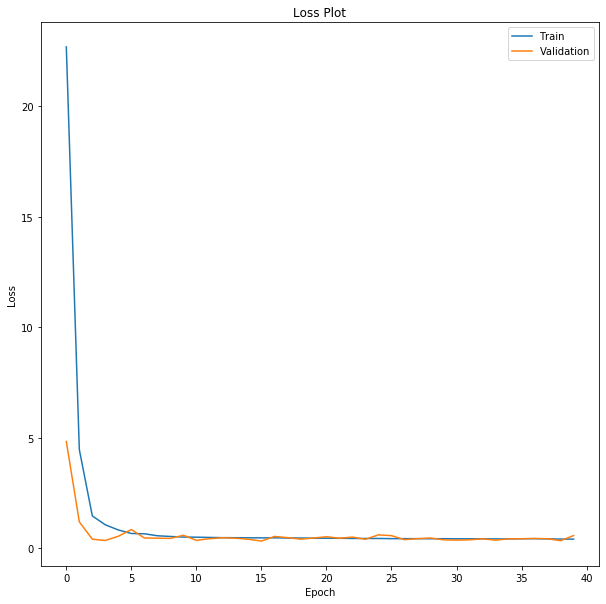

In [31]:
plt.plot(history_dense1.history['loss'])
plt.plot(history_dense1.history['val_loss'])
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

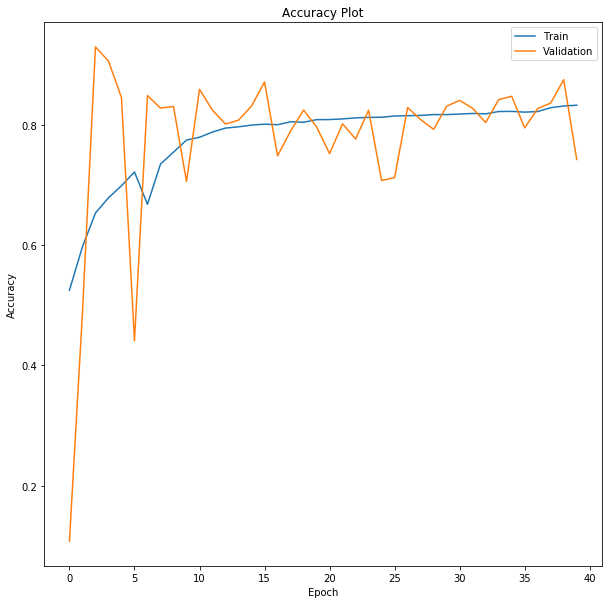

In [32]:
plt.plot(history_dense1.history['accuracy'])
plt.plot(history_dense1.history['val_accuracy'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [33]:
p_test = model_dense1.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, p_test[:,1], pos_label=1)
print('ROC area dense 1:', metrics.auc(fpr, tpr))


ROC area dense 1: 0.8422394920456577


In [34]:
#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix

pred_test = np.argmax(p_test, axis=1)
print(confusion_matrix(y_test, pred_test))
cf2=confusion_matrix(y_test, pred_test)

[[20721  7323]
 [  405  1551]]


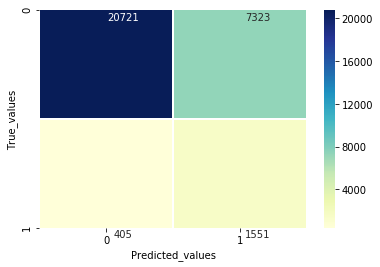

In [35]:
import seaborn as sns
import numpy as np; np.random.seed(0)
import matplotlib.pylab as plt
import matplotlib.transforms
#conf=confusion_matrix(y,pred)
plt.figure(figsize=(6,4))
ax=sns.heatmap(cf2,xticklabels=['0','1'],yticklabels=['0','1'],annot=True,fmt='d',cmap='YlGnBu',linewidths=0.5)
for t in ax.texts:
    trans = t.get_transform()
    offs = matplotlib.transforms.ScaledTranslation(0.13, 0.03,
                    matplotlib.transforms.IdentityTransform())
    t.set_transform( offs + trans )


plt.xlabel('Predicted_values')
plt.ylabel('True_values')
plt.show()

In [36]:
print(metrics.classification_report(y_test,pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.981     0.739     0.843     28044
           1      0.175     0.793     0.286      1956

    accuracy                          0.742     30000
   macro avg      0.578     0.766     0.565     30000
weighted avg      0.928     0.742     0.807     30000



### Model 3: A more dense architecture

In [37]:
input_data = tf.keras.layers.Input(batch_shape=(None, 12), dtype='float32', name='Input_data') 

dense1  = tf.keras.layers.Dense(256, activation='relu')(input_data)
dense2  = tf.keras.layers.Dense(128, activation='relu')(dense1)
dense3  = tf.keras.layers.Dense(64, activation='relu')(dense2)
dense4  = tf.keras.layers.Dense(64, activation='relu')(dense3)
dense5  = tf.keras.layers.Dense(32, activation='relu')(dense4)

output_data = tf.keras.layers.Dense(2, activation='softmax', name='Dense_output')(dense4)

model_dense2 = tf.keras.models.Model(inputs=input_data, outputs=output_data)
model_dense2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_data (InputLayer)      [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               3328      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
Dense_output (Dense)         (None, 2)                 130       
Total params: 48,770
Trainable params: 48,770
Non-trainable params: 0
_______________________________________________________

In [38]:
model_dense2.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


In [39]:
# Train the model

history_dense2 = model_dense2.fit(os_train_x, os_train_y, batch_size=128, epochs=40,
                                  verbose=1, validation_data=(X_test, y_test))

Train on 223860 samples, validate on 30000 samples
Epoch 1/40
223860/223860 [==============================] - 4s 16us/sample - loss: 3.2746 - accuracy: 0.5401 - val_loss: 0.4053 - val_accuracy: 0.8976
Epoch 2/40
223860/223860 [==============================] - 3s 15us/sample - loss: 0.8954 - accuracy: 0.5701 - val_loss: 0.4437 - val_accuracy: 0.8785
Epoch 3/40
223860/223860 [==============================] - 4s 16us/sample - loss: 0.6525 - accuracy: 0.6489 - val_loss: 0.5169 - val_accuracy: 0.7826
Epoch 4/40
223860/223860 [==============================] - 3s 15us/sample - loss: 0.6168 - accuracy: 0.6855 - val_loss: 0.7318 - val_accuracy: 0.5874
Epoch 5/40
223860/223860 [==============================] - 3s 15us/sample - loss: 0.6052 - accuracy: 0.7137 - val_loss: 0.4375 - val_accuracy: 0.8125loss: 0.6090 - ac - ETA: 0s - loss: 0.6042 - accura
Epoch 6/40
223860/223860 [==============================] - 3s 15us/sample - loss: 0.5048 - accuracy: 0.7645 - val_loss: 0.5807 - val_accuracy:

In [40]:
print(history_dense2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


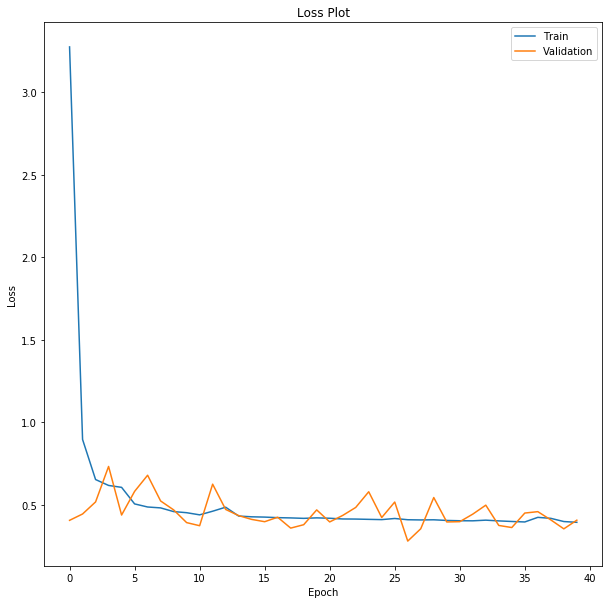

In [41]:
plt.plot(history_dense2.history['loss'])
plt.plot(history_dense2.history['val_loss'])
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

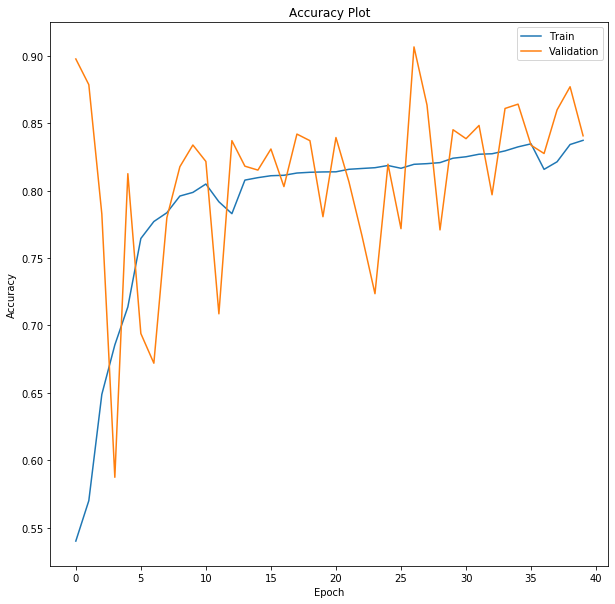

In [42]:
plt.plot(history_dense2.history['accuracy'])
plt.plot(history_dense2.history['val_accuracy'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [43]:
# Evaluate ROC
p_test = model_dense2.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, p_test[:,1], pos_label=1)
print('ROC area dense 2:', metrics.auc(fpr, tpr))


ROC area dense 2: 0.8495484309056845


In [44]:
#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix

pred_test = np.argmax(p_test, axis=1)
print(confusion_matrix(y_test, pred_test))
cf3=confusion_matrix(y_test, pred_test)

[[23918  4126]
 [  656  1300]]


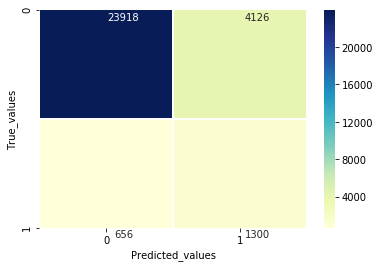

In [45]:
import seaborn as sns
import numpy as np; np.random.seed(0)
import matplotlib.pylab as plt
import matplotlib.transforms
#conf=confusion_matrix(y,pred)
plt.figure(figsize=(6,4))
ax=sns.heatmap(cf3,xticklabels=['0','1'],yticklabels=['0','1'],annot=True,fmt='d',cmap='YlGnBu',linewidths=0.5)
for t in ax.texts:
    trans = t.get_transform()
    offs = matplotlib.transforms.ScaledTranslation(0.13, 0.03,
                    matplotlib.transforms.IdentityTransform())
    t.set_transform( offs + trans )


plt.xlabel('Predicted_values')
plt.ylabel('True_values')
plt.show()

In [46]:
print(metrics.classification_report(y_test,pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.973     0.853     0.909     28044
           1      0.240     0.665     0.352      1956

    accuracy                          0.841     30000
   macro avg      0.606     0.759     0.631     30000
weighted avg      0.925     0.841     0.873     30000



### Model 4: Add regularization and early stopping

In [47]:
input_data = tf.keras.layers.Input(batch_shape=(None, 12), dtype='float32', name='Input_data') 

dense1  = tf.keras.layers.Dense(256, activation='relu')(input_data)

dense2  = tf.keras.layers.Dense(128, activation='relu')(dense1)

dense3  = tf.keras.layers.Dense(64, activation='relu')(dense2)

dense4  = tf.keras.layers.Dense(64, activation='relu')(dense3)
dense4 = tf.keras.layers.Dropout(0.5)(dense4)

dense5  = tf.keras.layers.Dense(32, activation='relu')(dense4)
dense5 = tf.keras.layers.Dropout(0.5)(dense5)

output_data = tf.keras.layers.Dense(2, activation='sigmoid', name='Dense_output')(dense5)


model_dense3 = tf.keras.models.Model(inputs=input_data, outputs=output_data)
model_dense3.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_data (InputLayer)      [(None, 12)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               3328      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080

In [48]:
model_dense3.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [49]:
from tensorflow.keras.callbacks import EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=50, 
    min_delta=0.001, 
    mode='max'
)

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [50]:
# Train the model

history_dense3 = model_dense3.fit(os_train_x, os_train_y, batch_size=128, epochs=100, verbose=1,callbacks=[custom_early_stopping] , validation_data=(X_test, y_test))

Train on 223860 samples, validate on 30000 samples
Epoch 1/100
223860/223860 [==============================] - 5s 21us/sample - loss: 0.7971 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.9344
Epoch 2/100
223860/223860 [==============================] - 4s 18us/sample - loss: 0.6996 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.9348
Epoch 3/100
223860/223860 [==============================] - 4s 19us/sample - loss: 0.6970 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.9348
Epoch 4/100
223860/223860 [==============================] - 4s 18us/sample - loss: 0.6983 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.9348
Epoch 5/100
223860/223860 [==============================] - 4s 19us/sample - loss: 0.6963 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.9348
Epoch 6/100
223860/223860 [==============================] - 4s 18us/sample - loss: 0.7002 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.9348
Epoch 7/100
223860/223860 [==========

In [51]:
print(history_dense3.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


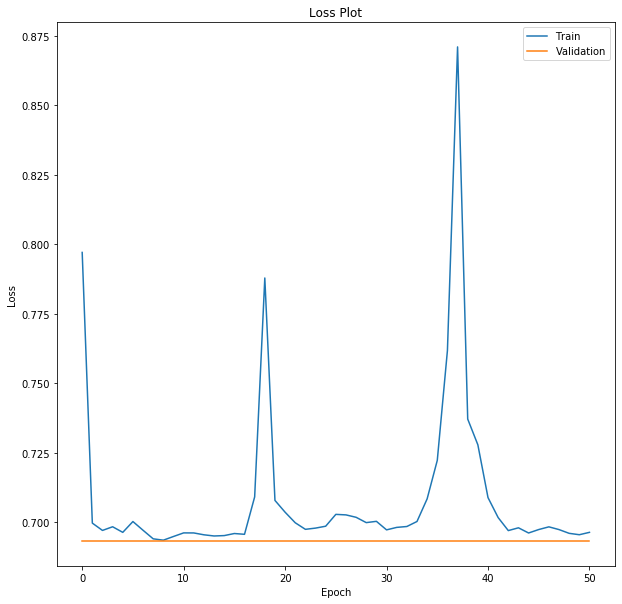

In [52]:
plt.plot(history_dense3.history['loss'])
plt.plot(history_dense3.history['val_loss'])
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

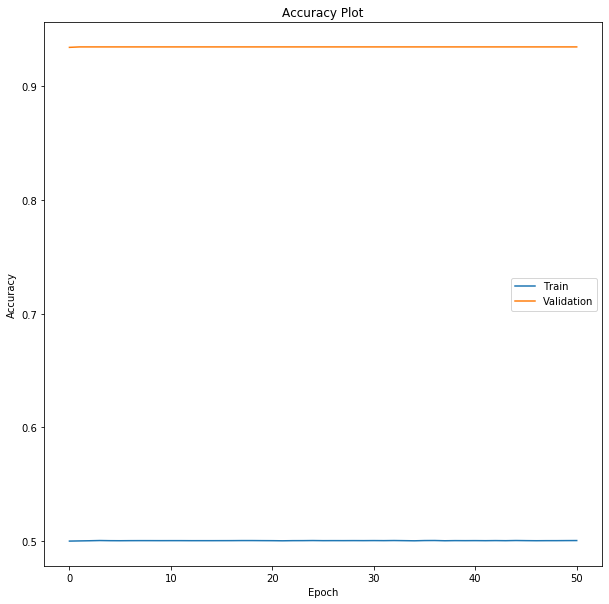

In [53]:
plt.plot(history_dense3.history['accuracy'])
plt.plot(history_dense3.history['val_accuracy'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [54]:
p_test = model_dense3.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, p_test[:,1], pos_label=1)
print('ROC area dense 3:', metrics.auc(fpr, tpr))

ROC area dense 3: 0.5


In [55]:
#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix

pred_test = np.argmax(p_test, axis=1)
print(confusion_matrix(y_test, pred_test))
cf4=confusion_matrix(y_test, pred_test)

[[28044     0]
 [ 1956     0]]


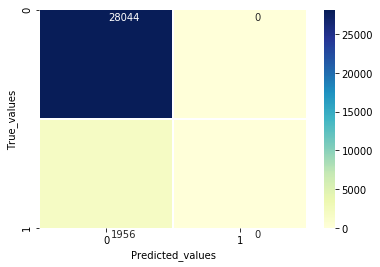

In [56]:
import seaborn as sns
import numpy as np; np.random.seed(0)
import matplotlib.pylab as plt
import matplotlib.transforms
#conf=confusion_matrix(y,pred)
plt.figure(figsize=(6,4))
ax=sns.heatmap(cf4,xticklabels=['0','1'],yticklabels=['0','1'],annot=True,fmt='d',cmap='YlGnBu',linewidths=0.5)
for t in ax.texts:
    trans = t.get_transform()
    offs = matplotlib.transforms.ScaledTranslation(0.13, 0.03,
                    matplotlib.transforms.IdentityTransform())
    t.set_transform( offs + trans )


plt.xlabel('Predicted_values')
plt.ylabel('True_values')
plt.show()

In [57]:
print(metrics.classification_report(y_test,pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.935     1.000     0.966     28044
           1      0.000     0.000     0.000      1956

    accuracy                          0.935     30000
   macro avg      0.467     0.500     0.483     30000
weighted avg      0.874     0.935     0.903     30000



### Predicting on the Test data

In [58]:
test_data= pd.read_csv("cs-test.csv", sep=',', header=0)
test_data=test_data.rename(columns = {'Unnamed: 0':'id'})

In [59]:
print(test_data.shape)
print(list(test_data.columns))
print((test_data.dtypes))

(101503, 12)
['id', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
id                                        int64
SeriousDlqin2yrs                        float64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object


In [60]:
test_data.drop("id", axis = 1, inplace= True)
test_data.drop("SeriousDlqin2yrs", axis = 1, inplace= True)


In [61]:
# Check missing values
print(test_data.isnull().sum(axis=0))

RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           20103
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       2626
dtype: int64


In [62]:
# Generate missing imputators variables.
test_data['MonthlyIncomeMissing'] = test_data.apply(lambda row: 1 if pd.isnull(row['MonthlyIncome']) else 0, axis=1)
test_data['NumberOfDependentsMissing'] = test_data.apply(lambda row: 1 if pd.isnull(row['NumberOfDependents']) else 0, axis=1)

# Impute missing values by the mean
test_data = test_data.fillna(test_data.mean())

In [63]:
print(test_data.isnull().sum(axis=0))

RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
MonthlyIncomeMissing                    0
NumberOfDependentsMissing               0
dtype: int64


In [64]:
test_data.shape

(101503, 12)

In [65]:
test_pred_unseen = model_dense2.predict(test_data)
test_pred_unseen = np.argmax(test_pred_unseen,axis=1)
test_pred_unseen2 = pd.DataFrame(test_pred_unseen)
test_pred_unseen2.to_csv("Testoutput.csv")